In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

# Download dataset from https://www.kaggle.com/datasets/puneet6060/intel-image-classification and extract it

train_dir = 'archive\\seg_test\\seg_test'
test_dir = 'archive\\seg_train\\seg_train'


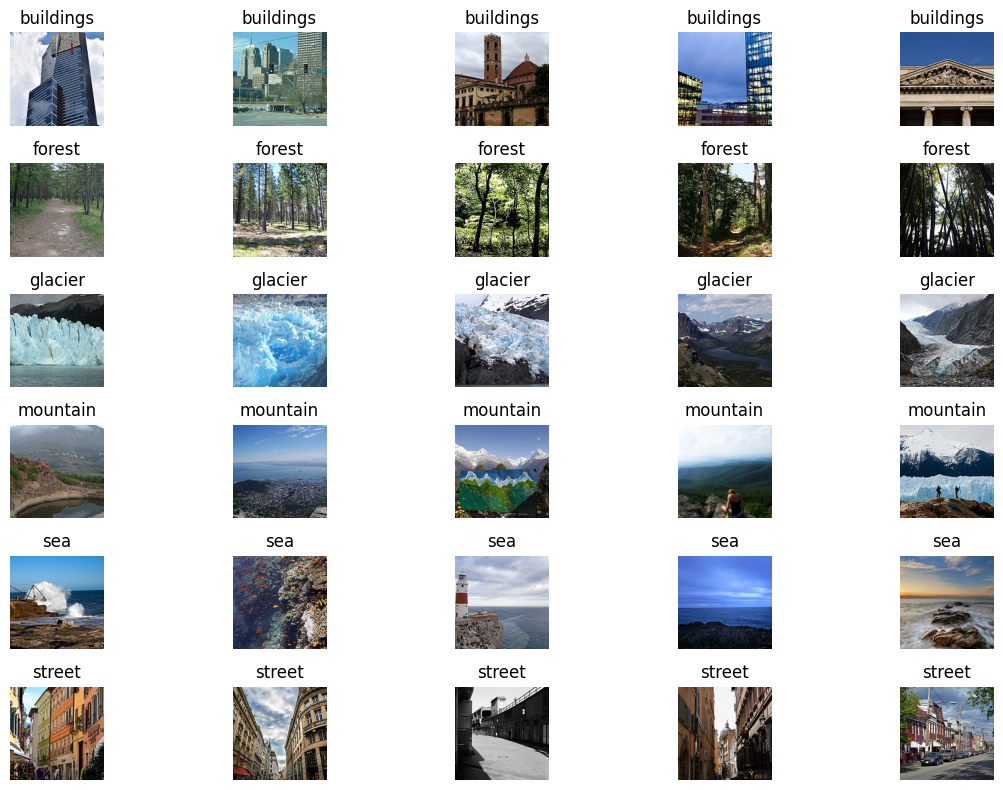

In [2]:
# Define a function to display sample images
def visualize_samples(data_dir, categories, n_samples=5):
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):
        folder_path = os.path.join(data_dir, category)
        for j, img_name in enumerate(os.listdir(folder_path)[:n_samples]):
            img_path = os.path.join(folder_path, img_name)
            img = plt.imread(img_path)
            plt.subplot(len(categories), n_samples, i * n_samples + j + 1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
visualize_samples(train_dir, categories)


In [4]:
# Image augmentation and data preparation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# CNN Model Architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')  # 6 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Found 2402 images belonging to 6 classes.
Found 598 images belonging to 6 classes.
Found 14034 images belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        256    

In [5]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=20  # Train for 20 epochs
)
 

Epoch 1/20
75/75 [==============================] - 51s 669ms/step - loss: 4.9143 - accuracy: 0.3401 - val_loss: 13.5444 - val_accuracy: 0.1701
Epoch 2/20
75/75 [==============================] - 30s 403ms/step - loss: 1.7834 - accuracy: 0.3186 - val_loss: 3.4623 - val_accuracy: 0.1736
Epoch 3/20
75/75 [==============================] - 31s 419ms/step - loss: 1.6820 - accuracy: 0.3468 - val_loss: 8.3934 - val_accuracy: 0.1701
Epoch 4/20
75/75 [==============================] - 32s 431ms/step - loss: 1.5696 - accuracy: 0.3852 - val_loss: 5.6184 - val_accuracy: 0.1736
Epoch 5/20
75/75 [==============================] - 32s 422ms/step - loss: 1.4556 - accuracy: 0.4000 - val_loss: 2.4110 - val_accuracy: 0.3420
Epoch 6/20
75/75 [==============================] - 31s 407ms/step - loss: 1.4581 - accuracy: 0.4224 - val_loss: 1.8809 - val_accuracy: 0.3247
Epoch 7/20
75/75 [==============================] - 31s 413ms/step - loss: 1.4453 - accuracy: 0.4152 - val_loss: 1.9086 - val_accuracy: 0.331

439/439 [==============================] - 150s 341ms/step - loss: 1.4709 - accuracy: 0.5561
Test Accuracy: 55.61%


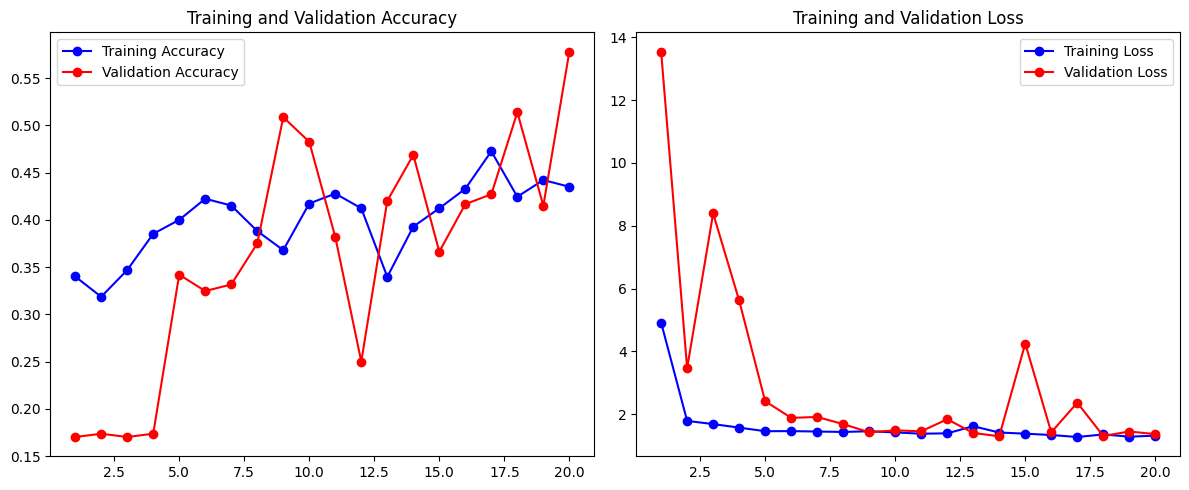

In [6]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plotting training and validation accuracy/loss
def plot_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_performance(history)


439/439 [==============================] - 48s 109ms/step


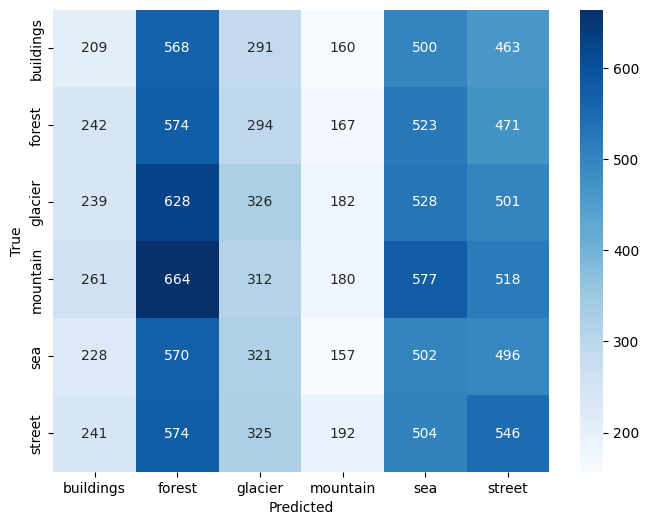

              precision    recall  f1-score   support

   buildings       0.15      0.10      0.12      2191
      forest       0.16      0.25      0.20      2271
     glacier       0.17      0.14      0.15      2404
    mountain       0.17      0.07      0.10      2512
         sea       0.16      0.22      0.19      2274
      street       0.18      0.23      0.20      2382

    accuracy                           0.17     14034
   macro avg       0.17      0.17      0.16     14034
weighted avg       0.17      0.17      0.16     14034



In [7]:
# Generate predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=categories))


Epoch 1/10
75/75 [==============================] - 31s 403ms/step - loss: 1.2286 - accuracy: 0.4823 - val_loss: 1.1728 - val_accuracy: 0.5990
Epoch 2/10
75/75 [==============================] - 32s 423ms/step - loss: 1.2023 - accuracy: 0.4755 - val_loss: 1.1099 - val_accuracy: 0.5833
Epoch 3/10
75/75 [==============================] - 33s 433ms/step - loss: 1.2014 - accuracy: 0.4781 - val_loss: 1.0982 - val_accuracy: 0.5885
Epoch 4/10
75/75 [==============================] - 32s 431ms/step - loss: 1.2063 - accuracy: 0.4941 - val_loss: 1.0820 - val_accuracy: 0.5868
Epoch 5/10
75/75 [==============================] - 33s 435ms/step - loss: 1.1701 - accuracy: 0.5076 - val_loss: 1.1328 - val_accuracy: 0.6163
Epoch 6/10
75/75 [==============================] - 33s 440ms/step - loss: 1.1557 - accuracy: 0.4895 - val_loss: 1.0950 - val_accuracy: 0.6181
Epoch 7/10
75/75 [==============================] - 33s 445ms/step - loss: 1.1364 - accuracy: 0.5092 - val_loss: 1.1901 - val_accuracy: 0.6094

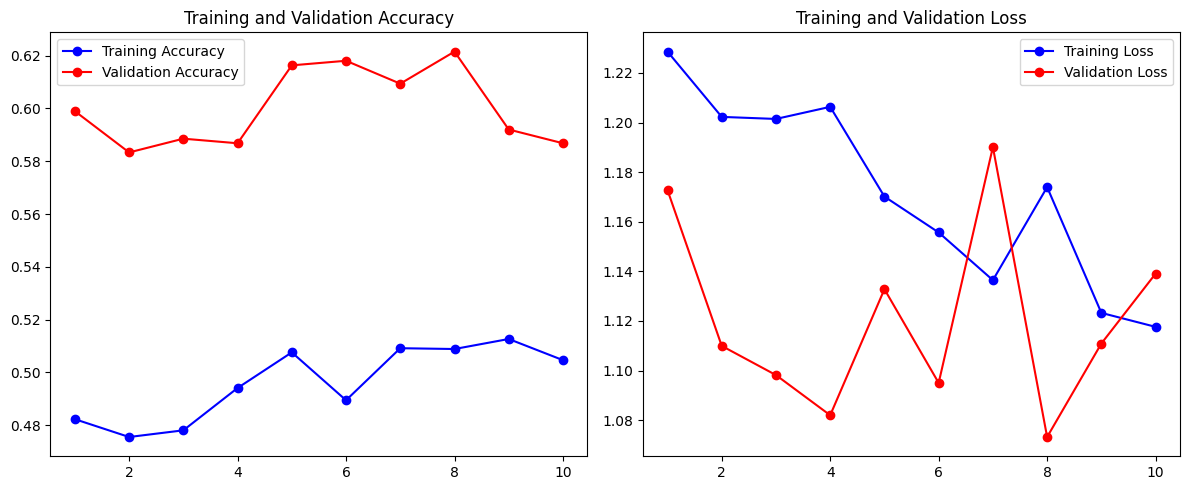

In [8]:
# Data Augmentation strategies have already been implemented during the data preparation phase
# Experiment with changing augmentation parameters or fine-tuning learning rate

# Example: Changing learning rate
from tensorflow.keras.optimizers import Adam
new_optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate

# Recompile model with new optimizer
model.compile(optimizer=new_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Retrain the model
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=10  # Fine-tune for 10 more epochs
)

plot_performance(history_fine_tune)
